In [3]:
from xradio.measurement_set.open_processing_set import open_processing_set
from astroviper.calibration.fringefit import fringefit_ps, apply_cal_ps
from xradio.measurement_set import convert_msv2_to_processing_set
import toolviper

import xarray as xa
import astropy.time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
msv2_name = "global_vlbi_gg084b_reduced.ms"
toolviper.utils.data.download(file=msv2_name)

convert_out = "gg084b"
partition_scheme = ["FIELD_ID", "SCAN_NUMBER", "SPW"]

convert_msv2_to_processing_set(
    in_file=msv2_name,
    out_file=convert_out,
    partition_scheme=partition_scheme,
    overwrite=True,
    parallel_mode="partition",
)

# This currently fails with a very long error message ending with
# "TypeError: Expected a BytesBytesCodec. Got <class 'numcodecs.zstd.Zstd'> instead."

[2025-10-27 14:21:10,039]     INFO  graphviper:  Module path: /home/small/LocalProjects/WorkingCopies/ngCasa/NRAO/toolviper/src/toolviper 
[2025-10-27 14:21:10,042]     INFO  graphviper:  Downloading from [cloudflare] .... 


 Download List                  
 ─────────────────────────────── 
  global_vlbi_gg084b_reduced.ms

[2025-10-27 14:21:10,046]     INFO  graphviper:  File exists: global_vlbi_gg084b_reduced.ms 


Output()

[2025-10-27 14:21:10,144]     INFO  graphviper:  Updated partition scheme used: ['DATA_DESC_ID', 'OBSERVATION_ID', 'FIELD_ID', 'SCAN_NUMBER'] 
[2025-10-27 14:21:10,146]     INFO  graphviper:  Number of partitions: 10 
[2025-10-27 14:21:10,147]     INFO  graphviper:  OBSERVATION_ID [0], DDI [0], STATE [None], FIELD [0], SCAN [3], EPHEMERIS [None] 
[2025-10-27 14:21:10,148]     INFO  graphviper:  OBSERVATION_ID [0], DDI [1], STATE [None], FIELD [0], SCAN [3], EPHEMERIS [None] 
[2025-10-27 14:21:10,148]     INFO  graphviper:  OBSERVATION_ID [0], DDI [0], STATE [None], FIELD [0], SCAN [319], EPHEMERIS [None] 
[2025-10-27 14:21:10,149]     INFO  graphviper:  OBSERVATION_ID [0], DDI [1], STATE [None], FIELD [0], SCAN [319], EPHEMERIS [None] 
[2025-10-27 14:21:10,149]     INFO  graphviper:  OBSERVATION_ID [0], DDI [0], STATE [None], FIELD [1], SCAN [320], EPHEMERIS [None] 
[2025-10-27 14:21:10,150]     INFO  graphviper:  OBSERVATION_ID [0], DDI [1], STATE [None], FIELD [1], SCAN [320], EPHEME

In [5]:
# The conversion appends ".ps.zarr" to the out_file it was given,
# But currently the conversion doesn't output a valid .zarr dataset anyway

ps = open_processing_set("gg084b.ps.zarr")

s = ps.xr_ps.summary()  # => Pandas table

baselines.values=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])


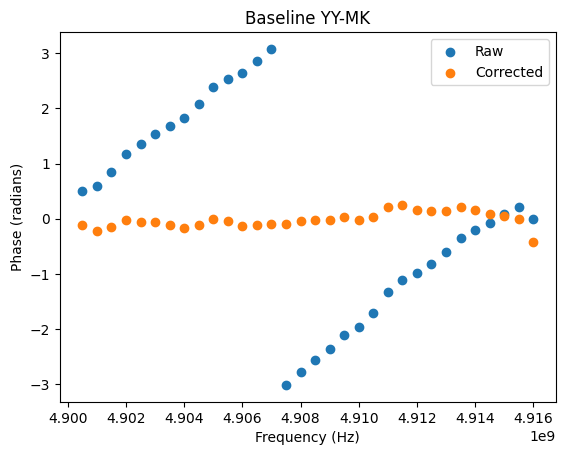

In [8]:
ff_start = astropy.time.Time("2018-05-27 07:15:00", format="iso").unix
ff_interval = 90

ref_ant = "MK"

cal_tree = fringefit_ps(ps, ref_ant, ff_start, ff_interval)
ps2 = apply_cal_ps(ps, cal_tree, ff_start, ff_interval)


def bl_inds(xds, a1, a2):
    return ((xds.baseline_antenna1_name == a1) & (xds.baseline_antenna2_name == a2) 
            | (xds.baseline_antenna1_name == a2) & (xds.baseline_antenna2_name == a1)).compute()


# We need an xds to get baselines from; I happen to know this one contains the interval we chose above
xds = ps2["global_vlbi_gg084b_reduced_8"]

ref_ant = "MK"
target_ant = "YY"

bl_bools = bl_inds(xds, ref_ant, target_ant)
[fdmk_index] = (xds.baseline_id[bl_bools]).compute().values
ant1 = xds.baseline_antenna1_name[fdmk_index].values
ant2 = xds.baseline_antenna2_name[fdmk_index].values
vis0 = np.angle(np.mean(xds["VISIBILITY"][:, fdmk_index, :, 0].squeeze(), axis=0))
vis1 = np.angle(
    np.mean(xds["VISIBILITY_CORRECTED"][:, fdmk_index, :, 0].compute().squeeze(), axis=0)
)
plt.figure()
plt.scatter(xds.frequency, vis0, label="Raw")
plt.scatter(xds.frequency, vis1, label="Corrected")
plt.title(f"Baseline {ant1}-{ant2}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (radians)")
plt.legend()
plt.show()